In [313]:
import json
import random
import matplotlib.pyplot as plt
import datetime
import numpy as np

def get_date(day_of_year, year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime.datetime(year, 1, 1)
    
    # Add the number of days to the base date to get the target date
    target_date = base_date + datetime.timedelta(days=day_of_year - 1)
    
    # Format the date as "{Month} {Day}, {Year}"
    formatted_date = target_date.strftime("%B %d, %Y")
    
    return formatted_date

def calculate_bias(data, historical_temps, weight_prev_year):
    # Calculate the bias from current data and historical data
    # Uses a weighted rolling bias that decreases linearly beyond extrapolation date
    # Rolling bias is weighted relative to the yearly average bias
    filtered_data = list(filter(lambda item: item is not None, data))
    # this includes la nina years so it isn't very good (need to fix)
    bias = [None] * 366
    bias_rolling = 0
    bias_total = 0
    bias_count = 0
    bias_avg = 0
    # only bias against recent era
    for i in range(0, len(historical_temps)):
        filtered_historical = list(filter(lambda item: item is not None, historical_temps[i]))
        historical_avg = sum(filtered_historical) / len(filtered_historical)
        if data[i]:
            bias_rolling = data[i] - historical_avg
            bias[i] = bias_rolling
            bias_total += bias_rolling
            bias_count += 1
        else:
            bias_prev_year = filtered_historical[len(filtered_historical) - 1] - historical_avg
            bias_avg = bias_total / bias_count
            extended = i - bias_count + 1
            days_left = 366 - extended
            # dumb interpolation for bias
            # decrease the weight of the rolling bias linearly in time against the bias_avg for this year so far
            weight = (days_left - extended) / days_left
            bias[i] = (weight * bias_rolling) + ((1 - weight) * (1 - weight_prev_year) * bias_avg) + ((1 - weight) * weight_prev_year * bias_prev_year)
    return bias

# run_extrapolation is very sensitive to the last observed data point
# only useful for providing upper-bounds when the last observed data point is at an assumed peak
def run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph):
    # Step 1: Load and parse the JSON file
    with open(filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    filtered_data = [entry for entry in data if len(entry['name']) == 4]

    # Step 3: Separate historical data and partially filled in data from extrapolate_year
    historical_data = [entry for entry in filtered_data if int(entry['name']) < extrapolate_year]
    partial_data = [entry for entry in filtered_data if int(entry['name']) == extrapolate_year]

    # Step 4: Extract historical temperatures for each day
    historical_temps = [[] for _ in range(366)]
    for entry in historical_data:
        for i, temp in enumerate(entry['data']):
            historical_temps[i].append(temp)

    # Step 5: Monte Carlo simulations to fill in missing data for projected year
    bias = [None] * 366
    simulated_data_adj = []
    max_obs_temp = 0
    start_index = 0
    for entry in partial_data:
        filtered_data = list(filter(lambda item: item is not None, entry['data']))
        max_obs_temp = max(filtered_data)
        num_missing_values = entry['data'].count(None)
        simulated_temps_adj = [None] * 366
        start_index = entry['data'].index(None)  # Index where missing data starts

        bias = calculate_bias(entry['data'], historical_temps, weight_prev_year)
        for i in range(start_index, start_index + num_missing_values):
            count = 0
            simulated_total = 0
            while count < n:
                c = random.choice(historical_temps[i])
                if c:
                    if bias[i]:
                        simulated_total += c + bias[i]
                    else:
                        simulated_total += c
                    count += 1
            simulated_temps_adj[i] = simulated_total / n
        simulated_data_adj.append({'name': entry['name'], 'data': simulated_temps_adj})

    if graph:
        # code for looking at graphs and printing out all temps
        print(f"Observed maximum: {max_obs_temp}")
        print(f"Possible days of observed maximum being exceeded:")
        print(f"(Projected) Dates where observed maximum is surpassed : Temp (C)")
        for i in range(start_index, 366):
            temp = simulated_data_adj[0]['data'][i]
            if temp > max_obs_temp:
                formatted_date = get_date(i + 1, extrapolate_year)
                count += 1
                temp_str = str(round(temp, 3))
                print(f"{formatted_date}: {temp_str}")
    else:
        # count record breaking days up to last_day
        count = 0
        for i in range(start_index, last_day):
            temp = simulated_data_adj[0]['data'][i]
            if temp > max_obs_temp:
                #formatted_date = get_date(i + 1, extrapolate_year)
                count += 1
                #temp_str = str(round(temp, 3))
                #print(f"{formatted_date}: {temp_str}")
        return count

    # Step 6: Create a graph with simulated temperature data for projected year
    x = range(1, len(partial_data[0]['data']) + 1)
    y = partial_data[0]['data']
    fig, ax = plt.subplots()
    lbl = 'Observed ' + str(extrapolate_year) + ' Data'
    ax.plot(x, y, label=lbl)
    # use commented plots to examine the biases
    ax.plot(x, simulated_data_adj[0]['data'], label='Simulated Data with Adjusted Bias')

    ax.set_xlabel('Day')
    ax.set_ylabel('Temperature')
    lbl = 'Simulated Temperature Data for ' + str(extrapolate_year)
    ax.set_title(lbl)
    ax.legend()
    plt.show()
    
def get_days_in_year(year):
    if year % 4 == 0:
        if year % 100 == 0:
            if year % 400 == 0:
                return 366  # Leap year (divisible by 400)
            else:
                return 365  # Not a leap year (divisible by 100 but not by 400)
        else:
            return 366  # Leap year (divisible by 4 but not by 100)
    else:
        return 365  # Not a leap year
    
# calc future temperature variability rises from single reference points (observed daily temperatures)
def calc_max_rise_plus_days(filepath, days_out, rise_threshold):
    # Step 1: Load and parse the JSON file
    with open(filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    filtered_data = [entry for entry in data if len(entry['name']) == 4]

    # only for counting years of data (current year is incomplete so reduce by 1)
    num_years_of_complete_data = len(filtered_data) - 1
    
    # Step 4: Extract temperature series data
    temp_series = []  # Assuming 365 days in a year, no leap years
    start_year = 0
    for entry in filtered_data:
        if start_year == 0:
            start_year = int(entry['name'])
        for i, temp in enumerate(entry['data']):
            # ignore null values (null place holders at the end of the data for non-leap years)
            if temp:
                temp_series.append(temp)
    
    # hold the maximum rise in temperatures relative to the current day, for the next days_out days
    #max_rise_temps = [[] for _ in range(366)]
    max_rise_temps = np.zeros(366)
    rise_occurrences = np.zeros(366)
    rise_avg_total = np.zeros(366)
    rise_threshold_occurrences = np.zeros(366)
    cur_year = start_year
    days_in_cur_year = get_days_in_year(cur_year)
    cur_year_days_done = 0
    temp_series_len = len(temp_series)
    # calculate max for every day except the last day of observations (since we expect a days_out > 0)
    for i in range(0, temp_series_len - 1):
        
        # end_range should be i + 1 + days_out
        # so for days_out of 1, the range will be i + 1, to i + 1 + 1, which is one day
        start_range = i + 1
        end_range = start_range + days_out
        if end_range > temp_series_len:
            # no further than the length of the series
            end_range = temp_series_len
        
        # get the next days_out max temp
        max_rise = 0
        ref_temp = temp_series[i]
        for j in range(start_range, end_range):
            rise = temp_series[j] - ref_temp
            if rise > 0:
                rise_occurrences[cur_year_days_done] += 1
                rise_avg_total[cur_year_days_done] += rise
                if rise > rise_threshold:
                    rise_threshold_occurrences[cur_year_days_done] += 1
            if rise > max_rise:
                max_rise = rise
            if max_rise_temps[cur_year_days_done]:
                if max_rise > max_rise_temps[cur_year_days_done]:
                    max_rise_temps[cur_year_days_done] = max_rise
            else:
                max_rise_temps[cur_year_days_done] = max_rise
        
        # keep track of current day of the year
        cur_year_days_done += 1
        # move to next year when done with current year
        if cur_year_days_done == days_in_cur_year:
            cur_year += 1
            days_in_cur_year = get_days_in_year(cur_year)
            cur_year_days_done = 0
    
    return [max_rise_temps, rise_occurrences, num_years_of_complete_data, rise_avg_total, rise_threshold_occurrences]
    
    
def graph_max_rise_plus_days(filepath, extrapolate_year, days_out, start_day_1_index, rise_threshold, include_days_plus_minus):    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig2, ac = plt.subplots()
    fig3, ap = plt.subplots()    
    
    for d in days_out:
        max_rise_temps, rise_occurrences, num_years_of_complete_data, rise_avg_total, rise_threshold_occurrences = calc_max_rise_plus_days(filepath, d, rise_threshold)
        
        rise_avg = np.zeros(len(rise_avg_total))
        for i in range(0, len(rise_avg)):
            rise_avg[i] = rise_avg_total[i] / rise_occurrences[i]
        
        # day of year (1-index)
        i = start_day_1_index
        print(f"Max 2m Temp Rise (historically) {d} days out from " + get_date(i, extrapolate_year))
        print(round(max_rise_temps[i-1],3))
        print("")
        
        print(f"# Occurences 2m Temp Rise (historically) {d} days out from " + get_date(i, extrapolate_year))
        print(str(int(rise_occurrences[i-1])))
        print("")

        # rough number since it will be either 44 or 45 through out the year
        denominator_days = d * num_years_of_complete_data
        # rise_occurences is the total number of days (across all years) that rises were counted for out of the d number of days looking forward from the reference day
        # since there are only d days and a number of years in the record we only looked at denominator_days for rise_occurences
        rise_prob = rise_occurrences[i-1] / denominator_days
        pct = round(rise_prob * 100,2)
        print(f"Chance of 2m temp rise {d} days out from " + get_date(i, extrapolate_year))
        print(str(pct) + " %")
        print("")

        # In addition to using a single reference day, let's look at the probabilities forward/backwards for temp rise
        start = i - include_days_plus_minus
        end = i + include_days_plus_minus
        days_in_year = get_days_in_year(extrapolate_year)
        for s in range(start, end + 1):
            # 366 for non-leap year will become 0
            m = s % (days_in_year + 1)
            # rough number since it will be either 44 or 45 through out the year
            denominator_days = d * num_years_of_complete_data
            # rise_occurences is the total number of days (across all years) that rises were counted for out of the d number of days looking forward from the reference day
            # since there are only d days and a number of years in the record we only looked at denominator_days for rise_occurences
            rise_prob = rise_occurrences[m-1] / denominator_days
            pct = round(rise_prob * 100,2)
            #print(f"Chance of temp rise {d} days out from " + get_date(m, extrapolate_year))
            #print(str(pct) + " %")
            #print("")
        
        print("Average 2m temperature rise conditioned on only days that have positive rise:")
        avg_rise = round(rise_avg[i-1],3)
        print(f"{avg_rise}")
        print("")
        
        expected_temp_rise = round(rise_prob * rise_avg[i-1], 3)
        rise_threshold_str = str(round(rise_threshold, 3))
        print(f"(Max) Expected Positive Temperature rise {d} days out from " + get_date(i, extrapolate_year))
        print(f"{expected_temp_rise}")
        print("")
        
        print(f"# Occurrences 2m Temp Rise exceeding a {rise_threshold_str} threshold, {d} days out from " + get_date(i, extrapolate_year))
        print(str(int(rise_threshold_occurrences[i-1])))
        print("")
        
        ratio_threshold_occ = rise_threshold_occurrences[i-1] / rise_occurrences[i-1]
        print(f"Ratio of Occurrences in 2m Temp Rise to Occurrences exceeding a {rise_threshold_str} threshold {d} days out from " + get_date(i, extrapolate_year))
        print(round(ratio_threshold_occ, 3))
        print("")
        
        prob_new_record_from_reference_day = ratio_threshold_occ * rise_prob
        new_record_pct = round(prob_new_record_from_reference_day * 100,2)
        print(f"Chance of 2m temp rise exceeding a {rise_threshold_str} threshold, {d} days out from " + get_date(i, extrapolate_year))
        print(str(round(new_record_pct, 2)) + " %")
        print("")
        print("")

        # In addition to using a single reference day, let's look at the probabilities forward/backwards for temp rise meeting threshold
        start = i - include_days_plus_minus
        end = i + include_days_plus_minus
        days_in_year = get_days_in_year(extrapolate_year)
        # store values for sensitivity graph
        chances_exceeding_threshold_y = []
        chances_exceeding_threshold_x = []
        
        for s in range(start, end + 1):
            # 366 for non-leap year will become 0
            m = s % (days_in_year + 1)
            ratio_threshold_occ = rise_threshold_occurrences[m-1] / rise_occurrences[m-1]
            prob_new_record_from_reference_day = ratio_threshold_occ * rise_prob
            new_record_pct = round(prob_new_record_from_reference_day * 100,2)
            chances_exceeding_threshold_y.append(new_record_pct)
            chances_exceeding_threshold_x.append(m)
            #print(f"Chance of 2m temp rise exceeding a {rise_threshold_str} threshold, {d} days out from " + get_date(m, extrapolate_year))
            #print(round(new_record_pct, 2))
        print("")
        print("")
        
        # Step 6: Create graphs
        x = range(1, len(max_rise_temps) + 1)
        y = max_rise_temps
        lbl = 'Max Temp Rise for ' + str(d) + ' days out'
        
        ax.set_xticks(x[172:213])
        ax.set_xticklabels(x[172:213])
        # add line for threshold to rise
        ax.axhline(y=rise_threshold, linestyle='dashed', color='red')
        #ax.plot(x, y, label=lbl)
        # zoom in
        ax.plot(x[172:213], y[172:213], label=lbl)

        x2 = range(1, len(max_rise_temps) + 1)
        y2 = rise_occurrences
        lbl2 = '# Occurrences of Global 2m Temp Rising ' + str(d) + ' days out'
        ac.plot(x2, y2, label=lbl2)
        
        lbl3 = '% Chance exceeding threshold, ' + str(d) + ' days out'
        ap.plot(chances_exceeding_threshold_x, chances_exceeding_threshold_y, label=lbl3)

    ax.set_xlabel('Day')
    ax.set_ylabel('Max Temp Rise')
    lbl = 'Max Rise in Global 2m Temp Rise for up to ' + str(d) + ' days out'
    ax.set_title(lbl)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    
    ac.set_xlabel('Day')
    ac.set_ylabel('# Occurrences of 2m Temp Rise')
    lbl = '# Occurrences of Global 2m Temp Rising for up to ' + str(d) + ' days out'
    ac.set_title(lbl)
    ac.legend(loc='upper right', bbox_to_anchor=(1.95, 1))
    
    # Sensitivity analysis
    ap.set_xlabel('Reference day (from which we count temp rises after in time)')
    ap.set_ylabel('% Chance of exceeding the threshold')
    lbl = '% Chance of 2m temp rise exceeding a ' + rise_threshold_str + ' threshold, counting forward from reference day'
    ap.set_title(lbl)
    ap.legend(loc='upper right', bbox_to_anchor=(1.75, 1))
    
    plt.show()




In [314]:
#### CONFIG FOR MAIN PARAMETERS
# number of simulations to average
n = 1000
# current year want to extrapolate data for that already have partial data
extrapolate_year = 2023
# also weight for previous year against bias avg for this year
# in other words, how large will the bias at the end of this year be from the avg bias calculated of this year so far from the historical average
# use a range of them to get a better idea
weights_prev_year = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 0.16, 0.32, 0.64, 0.99]
# file path to local copy of json wih temp data
# from https://climatereanalyzer.org/clim/t2_daily/json/cfsr_world_t2_day.json
filepath = 'cfsr_world_t2_day.json'

In [315]:
# run_extrapolation is very sensitive to the last observed data point
# only useful for providing upper-bounds when the last observed data point is at an assumed peak

# CONFIG FOR SPECIFIC RUN
# last day of year of range to check record for (July 12)
last_day = 194

graph = False
formatted_date = get_date(last_day, extrapolate_year)
print(f"Projected # days where current record is broken {formatted_date} :")
repeats = int(n / 10)
print("========================================================")
print("Prev year weight: # days where current max temp record is broken")
for weight_prev_year in weights_prev_year:
    total = 0
    for i in range(0, repeats):
        total += run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph)
    avg = total / repeats
    print(f"{weight_prev_year}: {avg}")

Projected # days where current record is broken July 13, 2023 :
Prev year weight: # days where current max temp record is broken


KeyboardInterrupt: 

In [ ]:
# run_extrapolation is very sensitive to the last observed data point
# only useful for providing upper-bounds when the last observed data point is at an assumed peak

# CONFIG FOR SPECIFIC RUN
# last day of year of range to check record for (July 31)
last_day = 212

graph = False
formatted_date = get_date(last_day, extrapolate_year)
print(f"Projected # days where current record is broken {formatted_date} :")
repeats = int(n / 10)
print("========================================================")
print("Prev year weight: # days where current max temp record is broken")
for weight_prev_year in [0.001, 0.005, 0.01, 0.02, 0.04, 0.8, 0.16, 0.32, 0.64, 0.99]:
    total = 0
    for i in range(0, repeats):
        total += run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph)
    avg = total / repeats
    print(f"{weight_prev_year}: {avg}")

In [ ]:
# Graph and show extrapolations for a single run
# this is arbitrarily chosen
weight_prev_year = 0.2
graph = True
run_extrapolation(extrapolate_year, weight_prev_year, last_day, n, filepath, graph)

Max 2m Temp Rise (historically) 1 days out from July 12, 2023
0.088

# Occurences 2m Temp Rise (historically) 1 days out from July 12, 2023
28

Chance of 2m temp rise 1 days out from July 12, 2023
63.64 %

Average 2m temperature rise conditioned on only days that have positive rise:
0.04

(Max) Expected Positive Temperature rise 1 days out from July 12, 2023
0.017

# Occurrences 2m Temp Rise exceeding a 0.196 threshold, 1 days out from July 12, 2023
0

Ratio of Occurrences in 2m Temp Rise to Occurrences exceeding a 0.196 threshold 1 days out from July 12, 2023
0.0

Chance of 2m temp rise exceeding a 0.196 threshold, 1 days out from July 12, 2023
0.0 %




Max 2m Temp Rise (historically) 2 days out from July 12, 2023
0.213

# Occurences 2m Temp Rise (historically) 2 days out from July 12, 2023
55

Chance of 2m temp rise 2 days out from July 12, 2023
62.5 %

Average 2m temperature rise conditioned on only days that have positive rise:
0.053

(Max) Expected Positive Temperature rise 2 day

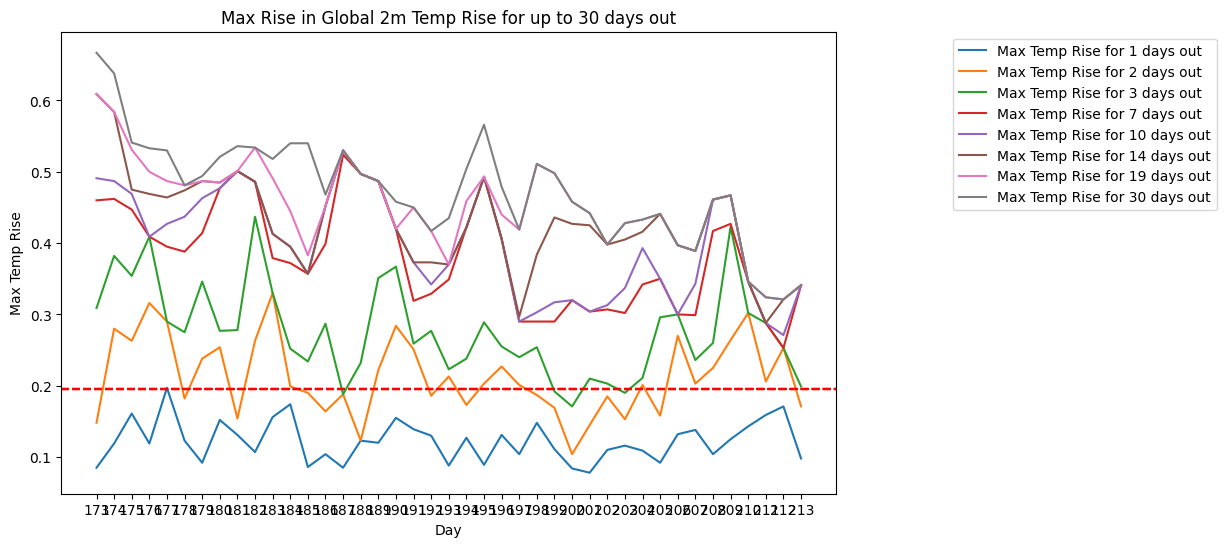

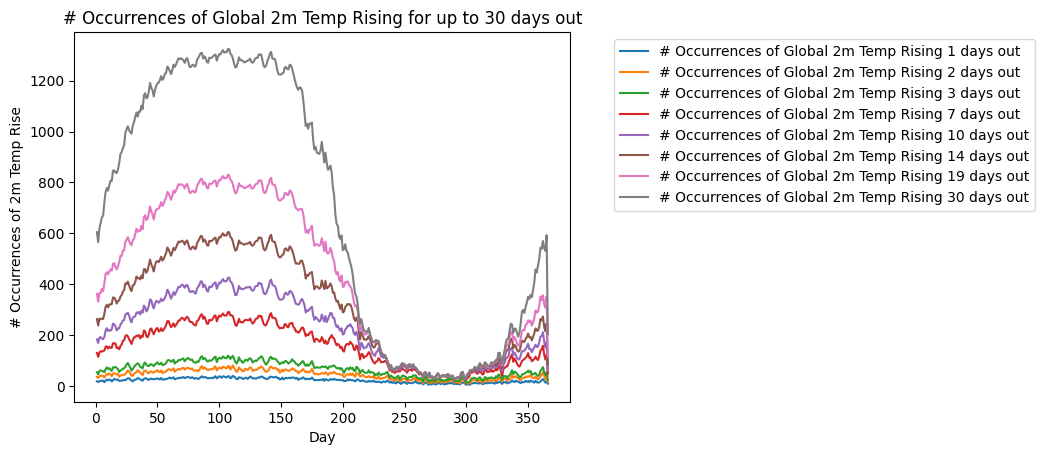

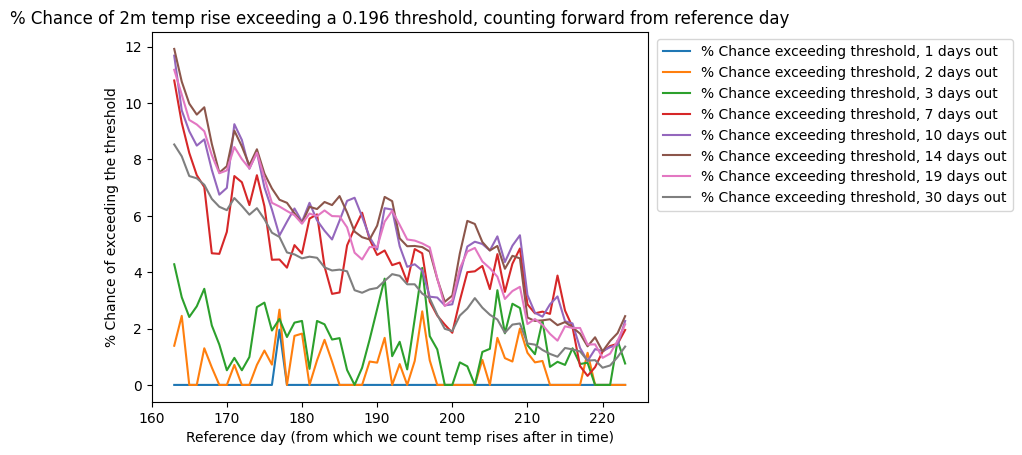

In [312]:
# start of day of year to project out from (last day of observed data: July 12, 2023 = 193)
start_day_1_index = 193
# threshold in rise to count occurences for (the record temperature - the most recent observation temperature)
rise_threshold = 17.233 - 17.037
# days out from last day of observed data to do counts for (22 + July 9 = July 31)
days_out = [1, 2, 3, 7, 10, 14, 19, 30]
#days_out = [1, 2, 3, 7, 22, 30]

# the temp variability changes throughout the year
# include probabilities for days prior/after reference day
include_days_plus_minus = 30

# the year for extrapolation
extrapolate_year = 2023
graph_max_rise_plus_days(filepath, extrapolate_year, days_out, start_day_1_index, rise_threshold, include_days_plus_minus)